In [1]:
import numpy as np
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:


from torchvision.models import resnet50
from torchvision import transforms
from tqdm import tqdm
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch
import time

In [3]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split  

In [4]:
from torchvision.models import resnet50


In [5]:
DATASET_PATH = "D:/CODING/WEB_DEV/Plant-Disease-classification-usingCNN/data/Plant_diseases"


In [6]:
trainTansform = transforms.Compose([
	transforms.RandomResizedCrop(224),
	transforms.RandomHorizontalFlip(),
	transforms.RandomRotation(90),
	transforms.ToTensor(),
])

valTransform = transforms.Compose([
	transforms.Resize((224, 224)),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.5,0.5 ,0.5], std=[0.5,0.5 ,0.5])
])

In [7]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

Using device: cpu


In [8]:
Total_Data = ImageFolder(DATASET_PATH, transform=trainTansform)

In [9]:
ClassIdx_dict = Total_Data.class_to_idx

In [10]:
Total_Data

Dataset ImageFolder
    Number of datapoints: 1210
    Root location: D:/CODING/WEB_DEV/Plant-Disease-classification-usingCNN/data/Plant_diseases
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )

In [11]:
ClassIdx_dict

{'Bacterial leaf blight': 0,
 'Blast': 1,
 'Brown spot': 2,
 'RedRot': 3,
 'Rust': 4,
 'Yellow': 5}

In [12]:
ClassIdx_dict = {i: class_name for i, class_name in enumerate(Total_Data.classes)}

In [13]:
NUM_CLASSES = len(ClassIdx_dict)
NUM_CLASSES

6

In [14]:
train_data , test_data= train_test_split(Total_Data,train_size=0.8,shuffle=True, random_state=42)

In [15]:
print('Number of training examples: {}'.format(len(train_data)))
print('Number of test examples: {}'.format(len(test_data)))

Number of training examples: 968
Number of test examples: 242


In [16]:

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True, pin_memory=True)

In [17]:

print('Number of training batches: {}'.format(len(train_loader)))
print('Number of test batches: {}'.format(len(test_loader)))

Number of training batches: 31
Number of test batches: 8


In [18]:
model = resnet50(pretrained=True)


for param in model.parameters():
	param.requires_grad = False
    
    

modelOutputFeats = model.fc.in_features
model.fc = nn.Linear(modelOutputFeats, NUM_CLASSES)
model = model.to(DEVICE)

d:\CODING\WEB_DEV\Plant-Disease-classification-usingCNN\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\CODING\WEB_DEV\Plant-Disease-classification-usingCNN\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
lossFunc = nn.CrossEntropyLoss()

opt = torch.optim.Adam(model.fc.parameters(), lr=0.0001)

In [20]:
H = {"train_loss": [], "train_acc": [], "val_loss": [],
	"val_acc": []}

In [21]:
EPOCHS=40

In [22]:

patience = 5  
best_val_loss = float("inf")
epochs_no_improve = 0

# Training loop
print("[INFO] training the network...")
startTime = time.time()




for e in tqdm(range(EPOCHS)):
    model.train()
    totalTrainLoss = 0
    totalValLoss = 0
    trainCorrect = 0
    valCorrect = 0

    
    for (i, (x, y)) in enumerate(train_loader):
        (x, y) = (x.to(DEVICE), y.to(DEVICE))

        pred = model(x)
        loss = lossFunc(pred, y)

        loss.backward()

        if (i + 1) % 2 == 0:
            opt.step()
            opt.zero_grad()

        totalTrainLoss += loss.item()
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

    
    with torch.no_grad():
        model.eval()
        for (x, y) in test_loader:
            (x, y) = (x.to(DEVICE), y.to(DEVICE))

            pred = model(x)
            totalValLoss += lossFunc(pred, y).item()
            valCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

    
    avgTrainLoss = totalTrainLoss / len(train_loader)
    avgValLoss = totalValLoss / len(test_loader)
    trainCorrect = trainCorrect / len(train_data)
    valCorrect = valCorrect / len(test_data)

    
    H["train_loss"].append(avgTrainLoss)
    H["train_acc"].append(trainCorrect)
    H["val_loss"].append(avgValLoss)
    H["val_acc"].append(valCorrect)

    print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(avgValLoss, valCorrect))


    if avgValLoss < best_val_loss:
        best_val_loss = avgValLoss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")
        print(f"[INFO] Validation loss improved; saving model at epoch {e + 1}")
    else:
        epochs_no_improve += 1
        print(f"[INFO] No improvement in validation loss for {epochs_no_improve} epoch(s)")

    if epochs_no_improve >= patience:
        print("[INFO] Early stopping triggered")
        break

endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))


[INFO] training the network...


  2%|▎         | 1/40 [00:49<32:13, 49.58s/it]

[INFO] EPOCH: 1/40
Train loss: 1.787941, Train accuracy: 0.1787
Val loss: 1.764506, Val accuracy: 0.2521
[INFO] Validation loss improved; saving model at epoch 1


  5%|▌         | 2/40 [01:40<31:46, 50.16s/it]

[INFO] EPOCH: 2/40
Train loss: 1.696386, Train accuracy: 0.3399
Val loss: 1.671510, Val accuracy: 0.4215
[INFO] Validation loss improved; saving model at epoch 2


  8%|▊         | 3/40 [02:31<31:22, 50.87s/it]

[INFO] EPOCH: 3/40
Train loss: 1.620272, Train accuracy: 0.4587
Val loss: 1.600249, Val accuracy: 0.5083
[INFO] Validation loss improved; saving model at epoch 3


 10%|█         | 4/40 [03:26<31:17, 52.16s/it]

[INFO] EPOCH: 4/40
Train loss: 1.553661, Train accuracy: 0.5258
Val loss: 1.541549, Val accuracy: 0.5248
[INFO] Validation loss improved; saving model at epoch 4


 12%|█▎        | 5/40 [04:22<31:23, 53.81s/it]

[INFO] EPOCH: 5/40
Train loss: 1.491638, Train accuracy: 0.5971
Val loss: 1.475485, Val accuracy: 0.5826
[INFO] Validation loss improved; saving model at epoch 5


 15%|█▌        | 6/40 [05:20<31:11, 55.03s/it]

[INFO] EPOCH: 6/40
Train loss: 1.431975, Train accuracy: 0.6705
Val loss: 1.420118, Val accuracy: 0.6281
[INFO] Validation loss improved; saving model at epoch 6


 18%|█▊        | 7/40 [06:17<30:38, 55.72s/it]

[INFO] EPOCH: 7/40
Train loss: 1.381573, Train accuracy: 0.6705
Val loss: 1.367601, Val accuracy: 0.6322
[INFO] Validation loss improved; saving model at epoch 7


 20%|██        | 8/40 [07:14<29:59, 56.23s/it]

[INFO] EPOCH: 8/40
Train loss: 1.327704, Train accuracy: 0.7066
Val loss: 1.333218, Val accuracy: 0.6777
[INFO] Validation loss improved; saving model at epoch 8


 22%|██▎       | 9/40 [08:11<29:12, 56.52s/it]

[INFO] EPOCH: 9/40
Train loss: 1.272943, Train accuracy: 0.7541
Val loss: 1.274133, Val accuracy: 0.6777
[INFO] Validation loss improved; saving model at epoch 9


 25%|██▌       | 10/40 [09:09<28:28, 56.96s/it]

[INFO] EPOCH: 10/40
Train loss: 1.243540, Train accuracy: 0.7252
Val loss: 1.248745, Val accuracy: 0.6860
[INFO] Validation loss improved; saving model at epoch 10


 28%|██▊       | 11/40 [10:06<27:31, 56.95s/it]

[INFO] EPOCH: 11/40
Train loss: 1.210807, Train accuracy: 0.7304
Val loss: 1.209110, Val accuracy: 0.7025
[INFO] Validation loss improved; saving model at epoch 11


 30%|███       | 12/40 [11:04<26:42, 57.23s/it]

[INFO] EPOCH: 12/40
Train loss: 1.161674, Train accuracy: 0.7459
Val loss: 1.180637, Val accuracy: 0.6942
[INFO] Validation loss improved; saving model at epoch 12


 32%|███▎      | 13/40 [12:02<25:49, 57.40s/it]

[INFO] EPOCH: 13/40
Train loss: 1.144780, Train accuracy: 0.7417
Val loss: 1.160105, Val accuracy: 0.7149
[INFO] Validation loss improved; saving model at epoch 13


 35%|███▌      | 14/40 [12:59<24:53, 57.46s/it]

[INFO] EPOCH: 14/40
Train loss: 1.096397, Train accuracy: 0.7665
Val loss: 1.113463, Val accuracy: 0.7273
[INFO] Validation loss improved; saving model at epoch 14


 38%|███▊      | 15/40 [13:57<23:54, 57.37s/it]

[INFO] EPOCH: 15/40
Train loss: 1.062489, Train accuracy: 0.7872
Val loss: 1.096875, Val accuracy: 0.7273
[INFO] Validation loss improved; saving model at epoch 15


 40%|████      | 16/40 [14:55<23:01, 57.55s/it]

[INFO] EPOCH: 16/40
Train loss: 1.042037, Train accuracy: 0.7686
Val loss: 1.076096, Val accuracy: 0.7355
[INFO] Validation loss improved; saving model at epoch 16


 42%|████▎     | 17/40 [15:47<21:26, 55.94s/it]

[INFO] EPOCH: 17/40
Train loss: 1.014789, Train accuracy: 0.7665
Val loss: 1.042981, Val accuracy: 0.7273
[INFO] Validation loss improved; saving model at epoch 17


 45%|████▌     | 18/40 [16:38<20:01, 54.63s/it]

[INFO] EPOCH: 18/40
Train loss: 0.991032, Train accuracy: 0.7820
Val loss: 1.030742, Val accuracy: 0.7397
[INFO] Validation loss improved; saving model at epoch 18


 48%|████▊     | 19/40 [17:30<18:48, 53.75s/it]

[INFO] EPOCH: 19/40
Train loss: 0.974743, Train accuracy: 0.7820
Val loss: 1.016316, Val accuracy: 0.7273
[INFO] Validation loss improved; saving model at epoch 19


 50%|█████     | 20/40 [18:22<17:42, 53.13s/it]

[INFO] EPOCH: 20/40
Train loss: 0.950795, Train accuracy: 0.7862
Val loss: 0.986006, Val accuracy: 0.7314
[INFO] Validation loss improved; saving model at epoch 20


 52%|█████▎    | 21/40 [19:13<16:40, 52.64s/it]

[INFO] EPOCH: 21/40
Train loss: 0.946916, Train accuracy: 0.7934
Val loss: 0.979565, Val accuracy: 0.7397
[INFO] Validation loss improved; saving model at epoch 21


 55%|█████▌    | 22/40 [20:05<15:42, 52.37s/it]

[INFO] EPOCH: 22/40
Train loss: 0.917293, Train accuracy: 0.7831
Val loss: 0.957220, Val accuracy: 0.7355
[INFO] Validation loss improved; saving model at epoch 22


 57%|█████▊    | 23/40 [20:57<14:46, 52.15s/it]

[INFO] EPOCH: 23/40
Train loss: 0.905405, Train accuracy: 0.7841
Val loss: 0.938102, Val accuracy: 0.7397
[INFO] Validation loss improved; saving model at epoch 23


 60%|██████    | 24/40 [21:48<13:53, 52.08s/it]

[INFO] EPOCH: 24/40
Train loss: 0.886073, Train accuracy: 0.8048
Val loss: 0.920514, Val accuracy: 0.7397
[INFO] Validation loss improved; saving model at epoch 24


 62%|██████▎   | 25/40 [22:40<13:00, 52.02s/it]

[INFO] EPOCH: 25/40
Train loss: 0.868945, Train accuracy: 0.7779
Val loss: 0.907714, Val accuracy: 0.7397
[INFO] Validation loss improved; saving model at epoch 25


 65%|██████▌   | 26/40 [23:32<12:07, 51.97s/it]

[INFO] EPOCH: 26/40
Train loss: 0.847131, Train accuracy: 0.7893
Val loss: 0.912434, Val accuracy: 0.7355
[INFO] No improvement in validation loss for 1 epoch(s)


 68%|██████▊   | 27/40 [24:24<11:13, 51.81s/it]

[INFO] EPOCH: 27/40
Train loss: 0.825978, Train accuracy: 0.8130
Val loss: 0.899068, Val accuracy: 0.7521
[INFO] Validation loss improved; saving model at epoch 27


 70%|███████   | 28/40 [25:15<10:21, 51.76s/it]

[INFO] EPOCH: 28/40
Train loss: 0.819916, Train accuracy: 0.7996
Val loss: 0.892195, Val accuracy: 0.7479
[INFO] Validation loss improved; saving model at epoch 28


 72%|███████▎  | 29/40 [26:07<09:30, 51.89s/it]

[INFO] EPOCH: 29/40
Train loss: 0.796377, Train accuracy: 0.8233
Val loss: 0.874069, Val accuracy: 0.7397
[INFO] Validation loss improved; saving model at epoch 29


 75%|███████▌  | 30/40 [26:59<08:38, 51.81s/it]

[INFO] EPOCH: 30/40
Train loss: 0.797955, Train accuracy: 0.8017
Val loss: 0.862169, Val accuracy: 0.7479
[INFO] Validation loss improved; saving model at epoch 30


 78%|███████▊  | 31/40 [27:51<07:46, 51.89s/it]

[INFO] EPOCH: 31/40
Train loss: 0.795682, Train accuracy: 0.7955
Val loss: 0.846675, Val accuracy: 0.7438
[INFO] Validation loss improved; saving model at epoch 31


 80%|████████  | 32/40 [28:43<06:55, 51.89s/it]

[INFO] EPOCH: 32/40
Train loss: 0.780662, Train accuracy: 0.8130
Val loss: 0.835805, Val accuracy: 0.7521
[INFO] Validation loss improved; saving model at epoch 32


 82%|████████▎ | 33/40 [29:35<06:02, 51.82s/it]

[INFO] EPOCH: 33/40
Train loss: 0.783383, Train accuracy: 0.8027
Val loss: 0.839353, Val accuracy: 0.7397
[INFO] No improvement in validation loss for 1 epoch(s)


 85%|████████▌ | 34/40 [30:27<05:11, 51.84s/it]

[INFO] EPOCH: 34/40
Train loss: 0.766343, Train accuracy: 0.8182
Val loss: 0.832733, Val accuracy: 0.7479
[INFO] Validation loss improved; saving model at epoch 34


 88%|████████▊ | 35/40 [31:18<04:19, 51.85s/it]

[INFO] EPOCH: 35/40
Train loss: 0.750986, Train accuracy: 0.8099
Val loss: 0.829511, Val accuracy: 0.7397
[INFO] Validation loss improved; saving model at epoch 35


 90%|█████████ | 36/40 [32:10<03:27, 51.89s/it]

[INFO] EPOCH: 36/40
Train loss: 0.744667, Train accuracy: 0.8182
Val loss: 0.810356, Val accuracy: 0.7603
[INFO] Validation loss improved; saving model at epoch 36


 92%|█████████▎| 37/40 [33:02<02:35, 51.89s/it]

[INFO] EPOCH: 37/40
Train loss: 0.724088, Train accuracy: 0.8223
Val loss: 0.804440, Val accuracy: 0.7479
[INFO] Validation loss improved; saving model at epoch 37


 95%|█████████▌| 38/40 [33:56<01:44, 52.34s/it]

[INFO] EPOCH: 38/40
Train loss: 0.716503, Train accuracy: 0.8285
Val loss: 0.804073, Val accuracy: 0.7645
[INFO] Validation loss improved; saving model at epoch 38


 98%|█████████▊| 39/40 [34:49<00:52, 52.53s/it]

[INFO] EPOCH: 39/40
Train loss: 0.702036, Train accuracy: 0.8264
Val loss: 0.792187, Val accuracy: 0.7521
[INFO] Validation loss improved; saving model at epoch 39


100%|██████████| 40/40 [35:46<00:00, 53.67s/it]

[INFO] EPOCH: 40/40
Train loss: 0.712511, Train accuracy: 0.8213
Val loss: 0.801785, Val accuracy: 0.7397
[INFO] No improvement in validation loss for 1 epoch(s)
[INFO] total time taken to train the model: 2147.00s


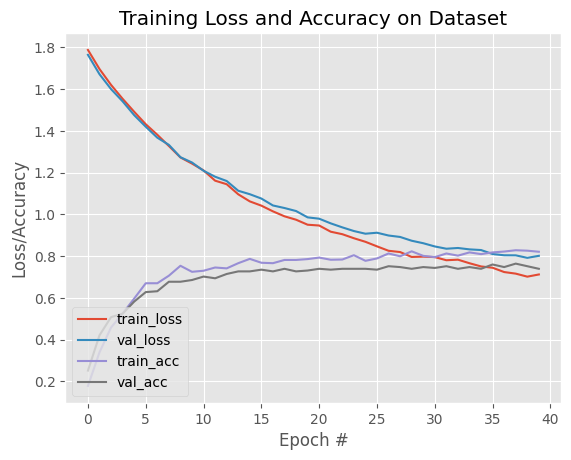

In [23]:

plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [24]:
PATH = "model_weights.pth"

In [25]:
torch.save(model.state_dict(), PATH)

[INFO] performing inference...


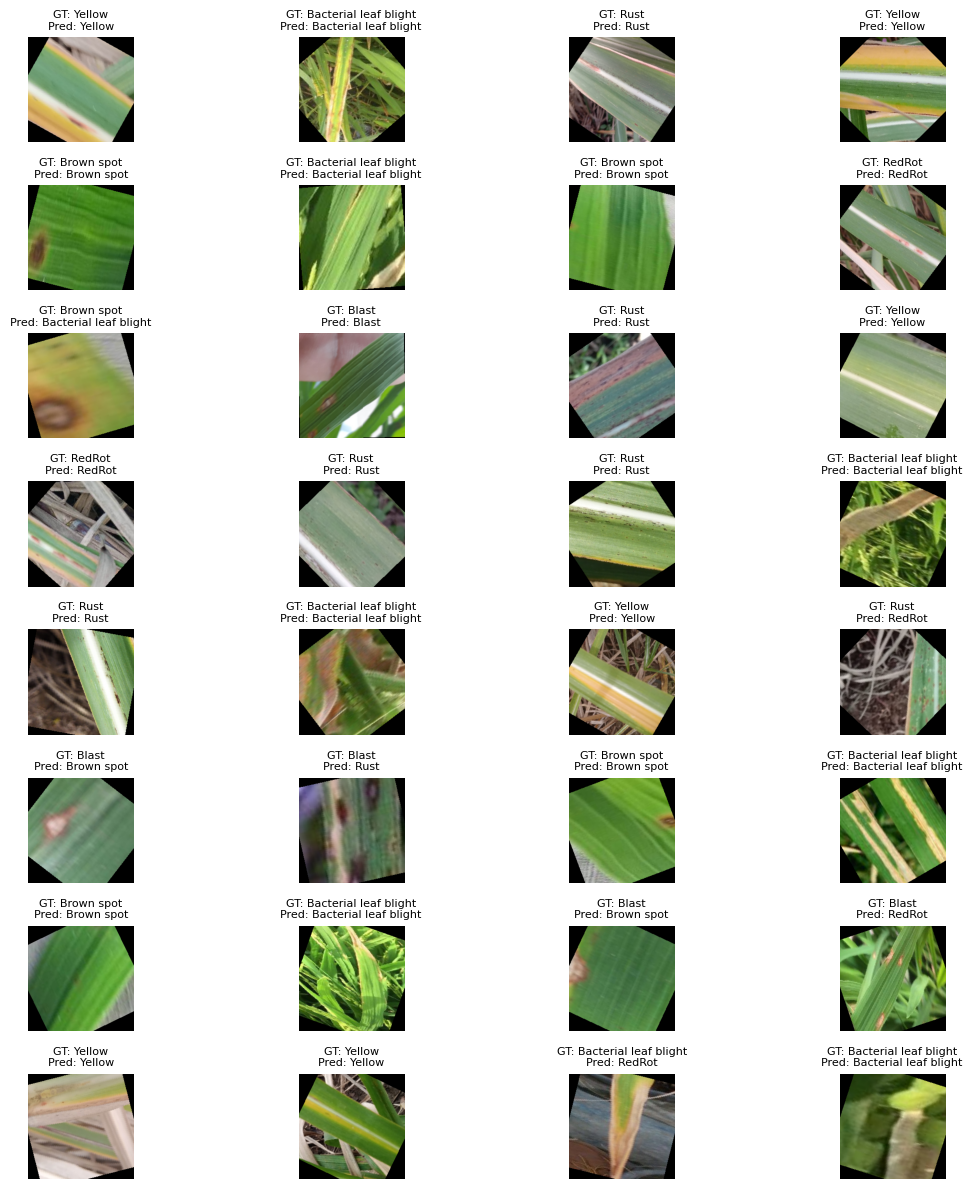

In [26]:

batch = next(iter(test_loader))
(images, labels) = (batch[0], batch[1])

fig = plt.figure("Results", figsize=(12, 12))

with torch.no_grad():
    
    images = images.to(DEVICE)
    
    print("[INFO] performing inference...")
    preds = model(images)
    
    for i in range(0, min(32, len(images))):  
        ax = plt.subplot(8, 4, i + 1)
        
        image = images[i]
        image = image.cpu().numpy()
        image = (image * 255).astype("uint8")
        image = image.transpose((1, 2, 0))  
        
        idx = labels[i].cpu().item()  
        gtLabel = ClassIdx_dict[idx]
        pred = preds[i].argmax().cpu().item()  
        predLabel = ClassIdx_dict[pred]
        
        info = f"GT: {gtLabel}\nPred: {predLabel}"
        plt.imshow(image)
        plt.title(info, fontsize=8)
        plt.axis("off")

plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.tight_layout()
plt.show()


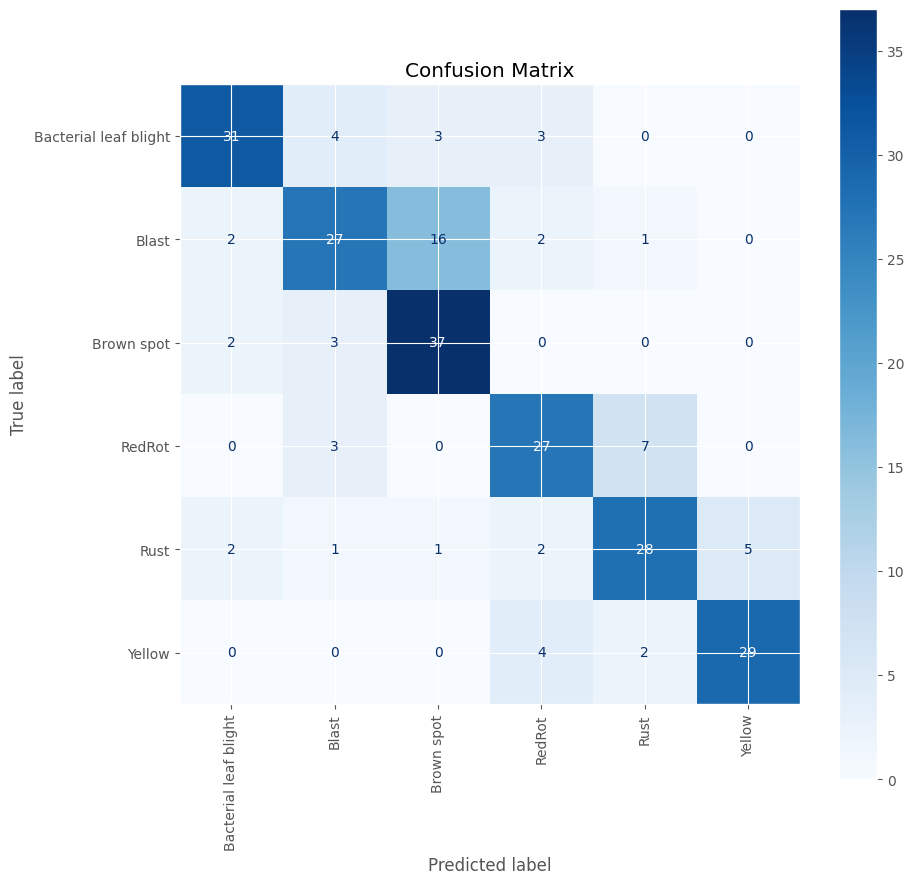

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

with torch.no_grad():
    model.eval()
    for (images, labels) in test_loader:

        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        preds = model(images)
        preds = preds.argmax(dim=1)  
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=ClassIdx_dict.values())


fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()